In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
import re

# Load the Hugging Face pipeline for Zero-Shot classification
zero_shot_classifier = pipeline("zero-shot-classification")

# Function to get Hugging Face response for Zero-Shot classification
def get_huggingface_response(prompt, model="facebook/bart-large-mnli", temperature=0.7):
    result = zero_shot_classifier(prompt, candidate_labels=["correct", "incorrect", "complete", "incomplete", "comprehensive", "incomplete"])
    return result['scores'][0]  # Return the score for the most likely label

# Function to compute correctness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_correctness_score(description, disease_term, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate how similar the disease term is to the description
    zero_shot_prompt = f"Evaluate the correctness of the disease description in relation to the disease term. The description: '{description}' and the disease term: '{disease_term}'. Rate the correctness on a scale from 0 to 1."

    correctness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return correctness_score_zero_shot


# Function to compute completeness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_completeness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate if the description covers all aspects of the disease
    zero_shot_prompt = f"Is the following disease description complete? Does it include key symptoms, diagnostic information, and relevant details about the disease? Describe any missing aspects. The description: '{description}'"

    completeness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return completeness_score_zero_shot


# Function to compute comprehensiveness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_comprehensiveness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate the comprehensiveness of the description
    zero_shot_prompt = f"Is the following disease description comprehensive? Does it include symptoms, diagnostic tests, treatments, and all relevant details? Rate the comprehensiveness on a scale from 0 to 1. The description: '{description}'"

    comprehensiveness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return comprehensiveness_score_zero_shot


# Few-shot Prompting Example for Correctness, Completeness, and Comprehensiveness
def few_shot_prompt(prompt, model="gpt2"):
    # Example 1: Correctness
    example_1 = "Description: 'A condition characterized by joint pain and stiffness. Often causes inflammation.' Disease Term: 'Arthritis'. Correctness: 0.8"
    example_2 = "Description: 'A disorder affecting the nervous system with symptoms of paralysis and muscle weakness.' Disease Term: 'Multiple Sclerosis'. Correctness: 0.9"

    # Example 2: Completeness
    example_3 = "Description: 'A disease caused by the flu virus, characterized by fever, chills, sore throat, and fatigue.' Completeness: 0.8"
    example_4 = "Description: 'A chronic condition involving high blood sugar levels and insulin resistance.' Completeness: 0.9"

    # Example 3: Comprehensiveness
    example_5 = "Description: 'A condition that involves an autoimmune response that attacks the joints.' Comprehensiveness: 0.7"
    example_6 = "Description: 'A mental health condition characterized by persistent sadness, feelings of hopelessness, and a lack of interest in daily activities.' Comprehensiveness: 0.85"

    # Combine the examples and prompt
    few_shot_examples = "\n".join([example_1, example_2, example_3, example_4, example_5, example_6])

    prompt_with_few_shot = f"{few_shot_examples}\n\n{prompt}"

    # Use the GPT-2 model from Hugging Face for Few-Shot Prompting
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForCausalLM.from_pretrained(model)

    inputs = tokenizer(prompt_with_few_shot, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=400, num_return_sequences=1, temperature=0.7)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the numerical score from the response
    match = re.search(r"(\d+\.\d+)", response)
    if match:
        return float(match.group(1))  # Return the extracted score
    else:
        return 0.0  # Return a default score in case no score is found


# Read the CSV file using pandas (replace 'your_file.csv' with the actual file path)
csv_file_path = 'MedMentions_Dataset.csv'  # Replace this with your actual CSV file path
df = pd.read_csv(csv_file_path)

# Initialize variables to accumulate scores for averaging
zero_shot_correctness_total = 0
zero_shot_completeness_total = 0
zero_shot_comprehensiveness_total = 0

few_shot_correctness_total = 0
few_shot_completeness_total = 0
few_shot_comprehensiveness_total = 0

# Evaluate the first few rows of the CSV file
num_rows = 7
for i in range(num_rows):
    description = df.iloc[i]['MentionTextSegment']  # Adjust the column name accordingly
    disease_term = df.iloc[i]['MatchingContent']  # Adjust the column name accordingly

    # Compute the scores using Zero-Shot and Few-Shot approaches

    # Zero-Shot Approach
    correctness_score_zero_shot = compute_correctness_score(description, disease_term)
    completeness_score_zero_shot = compute_completeness_score(description)
    comprehensiveness_score_zero_shot = compute_comprehensiveness_score(description)

    zero_shot_correctness_total += correctness_score_zero_shot
    zero_shot_completeness_total += completeness_score_zero_shot
    zero_shot_comprehensiveness_total += comprehensiveness_score_zero_shot

    print(f"Row {i+1} - Zero-Shot Correctness Score: {correctness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Completeness Score: {completeness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Comprehensiveness Score: {comprehensiveness_score_zero_shot}")

    # Few-Shot Approach
    few_shot_correctness_prompt = f"Evaluate the correctness of the disease description: '{description}' with the disease term: '{disease_term}'. Rate the correctness from 0 to 1."
    few_shot_completeness_prompt = f"Is the following disease description complete? Rate the completeness from 0 to 1. The description: '{description}'"
    few_shot_comprehensiveness_prompt = f"Evaluate if the description includes symptoms, diagnostic tests, and treatments. Rate the comprehensiveness from 0 to 1. The description: '{description}'"

    correctness_score_few_shot = few_shot_prompt(few_shot_correctness_prompt)
    completeness_score_few_shot = few_shot_prompt(few_shot_completeness_prompt)
    comprehensiveness_score_few_shot = few_shot_prompt(few_shot_comprehensiveness_prompt)

    few_shot_correctness_total += correctness_score_few_shot
    few_shot_completeness_total += completeness_score_few_shot
    few_shot_comprehensiveness_total += comprehensiveness_score_few_shot

    print(f"Row {i+1} - Few-Shot Correctness Score: {correctness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Completeness Score: {completeness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Comprehensiveness Score: {comprehensiveness_score_few_shot}")

# Calculate and print the average scores for Zero-Shot and Few-Shot
zero_shot_correctness_avg = zero_shot_correctness_total / num_rows
zero_shot_completeness_avg = zero_shot_completeness_total / num_rows
zero_shot_comprehensiveness_avg = zero_shot_comprehensiveness_total / num_rows

few_shot_correctness_avg = few_shot_correctness_total / num_rows
few_shot_completeness_avg = few_shot_completeness_total / num_rows
few_shot_comprehensiveness_avg = few_shot_comprehensiveness_total / num_rows

print(f"\nZero-Shot Average Correctness Score: {zero_shot_correctness_avg}")
print(f"Zero-Shot Average Completeness Score: {zero_shot_completeness_avg}")
print(f"Zero-Shot Average Comprehensiveness Score: {zero_shot_comprehensiveness_avg}")

print(f"\nFew-Shot Average Correctness Score: {few_shot_correctness_avg}")
print(f"Few-Shot Average Completeness Score: {few_shot_completeness_avg}")
print(f"Few-Shot Average Comprehensiveness Score: {few_shot_comprehensiveness_avg}")


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Row 1 - Zero-Shot Correctness Score: 0.3037741184234619
Row 1 - Zero-Shot Completeness Score: 0.4333570897579193
Row 1 - Zero-Shot Comprehensiveness Score: 0.3177729547023773


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 1 - Few-Shot Correctness Score: 0.8
Row 1 - Few-Shot Completeness Score: 0.8
Row 1 - Few-Shot Comprehensiveness Score: 0.8
Row 2 - Zero-Shot Correctness Score: 0.29976484179496765
Row 2 - Zero-Shot Completeness Score: 0.4333570897579193
Row 2 - Zero-Shot Comprehensiveness Score: 0.3177729547023773


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 2 - Few-Shot Correctness Score: 0.8
Row 2 - Few-Shot Completeness Score: 0.8
Row 2 - Few-Shot Comprehensiveness Score: 0.8
Row 3 - Zero-Shot Correctness Score: 0.3162427246570587
Row 3 - Zero-Shot Completeness Score: 0.4322035610675812
Row 3 - Zero-Shot Comprehensiveness Score: 0.3128163516521454


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 3 - Few-Shot Correctness Score: 0.8
Row 3 - Few-Shot Completeness Score: 0.8
Row 3 - Few-Shot Comprehensiveness Score: 0.8
Row 4 - Zero-Shot Correctness Score: 0.31633275747299194
Row 4 - Zero-Shot Completeness Score: 0.4317966401576996
Row 4 - Zero-Shot Comprehensiveness Score: 0.3159773647785187


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 4 - Few-Shot Correctness Score: 0.8
Row 4 - Few-Shot Completeness Score: 0.8
Row 4 - Few-Shot Comprehensiveness Score: 0.8
Row 5 - Zero-Shot Correctness Score: 0.34930673241615295
Row 5 - Zero-Shot Completeness Score: 0.4254850149154663
Row 5 - Zero-Shot Comprehensiveness Score: 0.318319708108902


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 5 - Few-Shot Correctness Score: 0.8
Row 5 - Few-Shot Completeness Score: 0.8
Row 5 - Few-Shot Comprehensiveness Score: 0.8
Row 6 - Zero-Shot Correctness Score: 0.31633275747299194
Row 6 - Zero-Shot Completeness Score: 0.4317966401576996
Row 6 - Zero-Shot Comprehensiveness Score: 0.3159773647785187


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 6 - Few-Shot Correctness Score: 0.8
Row 6 - Few-Shot Completeness Score: 0.8
Row 6 - Few-Shot Comprehensiveness Score: 0.8
Row 7 - Zero-Shot Correctness Score: 0.318731427192688
Row 7 - Zero-Shot Completeness Score: 0.4337688386440277
Row 7 - Zero-Shot Comprehensiveness Score: 0.3141212463378906


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 7 - Few-Shot Correctness Score: 0.8
Row 7 - Few-Shot Completeness Score: 0.8
Row 7 - Few-Shot Comprehensiveness Score: 0.8

Zero-Shot Average Correctness Score: 0.31721219420433044
Zero-Shot Average Completeness Score: 0.43168069635118755
Zero-Shot Average Comprehensiveness Score: 0.3161082778658186

Few-Shot Average Correctness Score: 0.7999999999999999
Few-Shot Average Completeness Score: 0.7999999999999999
Few-Shot Average Comprehensiveness Score: 0.7999999999999999


In [2]:
import pandas as pd
from tqdm import tqdm

# Function to extract unique pairs of MatchingContent and MentionTextSegment
def get_unique_pairs(df):
    unique_pairs = set()  # Store unique pairs in a set to avoid duplicates
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Entries"):
        pair = (row['MatchingContent'], row['MentionTextSegment'])
        unique_pairs.add(pair)
    return unique_pairs

# Function to calculate uniqueness and duplication scores for a dataset
def calculate_scores(df):
    unique_pairs = get_unique_pairs(df)
    total_entries = len(df)
    unique_pairs_count = len(unique_pairs)

    # Calculate scores
    uniqueness_score = unique_pairs_count / total_entries
    duplication_score = 1 - uniqueness_score  # Duplication score is the complement of uniqueness

    return uniqueness_score, duplication_score

# Load the dataset
dataset_path = 'MedMentions_Dataset.csv'
df = pd.read_csv(dataset_path)

# Calculate and print the scores for the dataset
uniqueness_score, duplication_score = calculate_scores(df)
print(f"Uniqueness Score: {uniqueness_score:.4f}")
print(f"Duplication Score: {duplication_score:.4f}")


Processing Entries: 100%|██████████| 382320/382320 [00:28<00:00, 13325.26it/s]

Uniqueness Score: 0.2947
Duplication Score: 0.7053


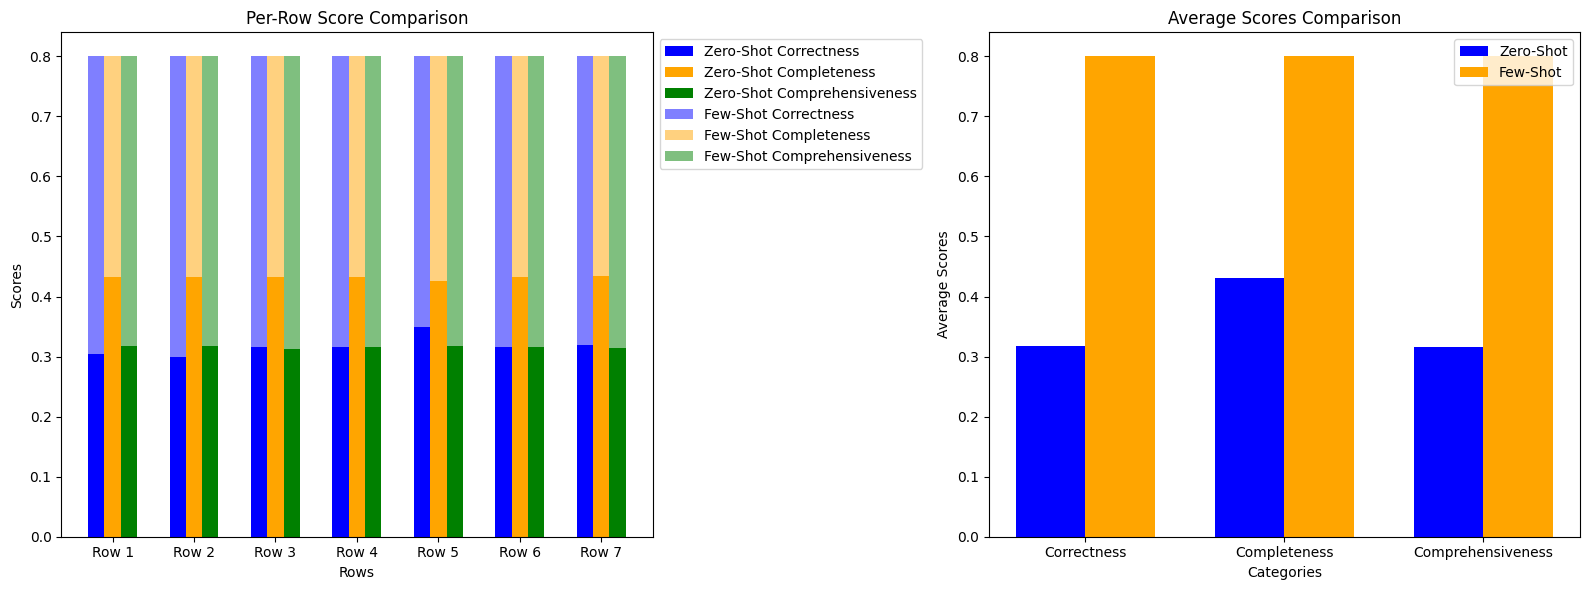

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each row
rows = [1, 2, 3, 4, 5, 6, 7]
zero_shot_correctness = [0.3037741184234619, 0.29976484179496765, 0.3162427246570587, 0.31633275747299194, 0.34930673241615295, 0.31633275747299194, 0.318731427192688]
zero_shot_completeness = [0.4333570897579193, 0.4333570897579193, 0.4322035610675812, 0.4317966401576996, 0.4254850149154663, 0.4317966401576996, 0.4337688386440277]
zero_shot_comprehensiveness = [0.3177729547023773, 0.3177729547023773, 0.3128163516521454, 0.3159773647785187, 0.318319708108902, 0.3159773647785187, 0.3141212463378906]
few_shot_correctness = [0.8] * len(rows)
few_shot_completeness = [0.8] * len(rows)
few_shot_comprehensiveness = [0.8] * len(rows)

# Averages
zero_shot_avg_correctness = 0.31721219420433044
zero_shot_avg_completeness = 0.43168069635118755
zero_shot_avg_comprehensiveness = 0.3161082778658186
few_shot_avg_correctness = 0.8
few_shot_avg_completeness = 0.8
few_shot_avg_comprehensiveness = 0.8

# Plotting Per-Row Comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Per-Row Scores
x = np.arange(len(rows))
width = 0.2

ax[0].bar(x - width, zero_shot_correctness, width, label='Zero-Shot Correctness', color='blue')
ax[0].bar(x, zero_shot_completeness, width, label='Zero-Shot Completeness', color='orange')
ax[0].bar(x + width, zero_shot_comprehensiveness, width, label='Zero-Shot Comprehensiveness', color='green')
ax[0].bar(x - width, few_shot_correctness, width, label='Few-Shot Correctness', color='blue', alpha=0.5)
ax[0].bar(x, few_shot_completeness, width, label='Few-Shot Completeness', color='orange', alpha=0.5)
ax[0].bar(x + width, few_shot_comprehensiveness, width, label='Few-Shot Comprehensiveness', color='green', alpha=0.5)

ax[0].set_xlabel('Rows')
ax[0].set_ylabel('Scores')
ax[0].set_title('Per-Row Score Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels([f'Row {i}' for i in rows])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Subplot 2: Average Scores
categories = ['Correctness', 'Completeness', 'Comprehensiveness']
zero_shot_avg_scores = [zero_shot_avg_correctness, zero_shot_avg_completeness, zero_shot_avg_comprehensiveness]
few_shot_avg_scores = [few_shot_avg_correctness, few_shot_avg_completeness, few_shot_avg_comprehensiveness]

x = np.arange(len(categories))
width = 0.35

ax[1].bar(x - width/2, zero_shot_avg_scores, width, label='Zero-Shot', color='blue')
ax[1].bar(x + width/2, few_shot_avg_scores, width, label='Few-Shot', color='orange')

ax[1].set_xlabel('Categories')
ax[1].set_ylabel('Average Scores')
ax[1].set_title('Average Scores Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(categories)
ax[1].legend()

plt.tight_layout()
plt.show()
